# Monetary Policy Expected Interest Rate - Peru

## <a> Outline </a>
- <a href='#model'> Model </a>
- <a href='#lib'> Libraries </a>
- <a href='#data'> Data Collection </a>
- <a href='#exp_r'> Expected Monetary Policy Interest Rate </a>
- <a href='#ref'>References</a>

## <a id='model'> Model </a>

For the estimation of the expected interest rate we are going to use the Taylor Rule adjusted to the Peruvian Economy, following Winkelried (2013, in <a href='#vega'>Vega 2019</a>)

$$i_{t} = \rho i_{t-1} + (1-\rho)[i^{*}+\phi_{\pi}(\pi^{e}_{t} - \bar{\pi}) + \phi_{y}(y_{t}-\bar{y}_{t})
]$$

where
- $i_{t}$ is the interest rate.
- $i_{t-1}$ is the lagged interest rate, used as inertial component.
- $i^{*}$ is the natural interest rate.
- $\pi^{e}_{t}$ is the expected inflation rate.
- $\bar{\pi}$ is the inflation target.
- $y_{t}$ is the GDP.
- $\bar{y}_{t}$ is the potential GDP.

with the following parameter calibration

| Paramether | Monthly | Quarterly |
| --- | --- | --- |
| $\rho$ | 0.89 | 0.7 |
| $\phi_{\pi}$ | 1.5 | 1.5 |
| $\phi_{y}$ | 0.5 | 0.5 |
| $i^{*}$ | 1.8 | 1.8 |

## <a id='lib'> Libraries </a>

In [1]:
import requests


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm


from statsmodels.tsa.filters.hp_filter import hpfilter

C:\Users\josed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\josed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## <a id='data'> Data Collection </a>

In [2]:
## Basic parameters
url_base="https://estadisticas.bcrp.gob.pe/estadisticas/series/api/"
formato="/json"
per="/2003-9/2022-6"

## List of variables
series_list = ["PD12912AM", # Inflation Expectation to 12 months
               "PD04722MM", # Monetary Policy Reference Rate
               "PN38081AM" # 3 months Seasonally adjusted GDP (index 2007=100)
              ]

## Empty dictionaries
url = {}
ans = {}
dfs = {}

## Loop to get variables from BCRP Request
for i in range(len(series_list)):
    url[series_list[i]] = url_base+series_list[i]+formato+per
    ans[series_list[i]] = requests.get(url[series_list[i]])
    dfs[series_list[i]] = pd.DataFrame(ans[series_list[i]].json()["periods"])
    dfs[series_list[i]]["values"] = dfs[series_list[i]]["values"].str[0].astype(float)
    
dates = dfs[series_list[i]]["name"]

df = pd.concat([dates,
                dfs["PD12912AM"]["values"],
                dfs["PD04722MM"]["values"],
                dfs["PN38081AM"]["values"]],
               axis=1,
               keys=['dates', 'inflation_e', 'mon_rate', 'gdp'])

## getting GDP cycle for GDP gap
df["gdp"] = np.log(df["gdp"])
gdp_cycle, gdp_trend = hpfilter(df['gdp'], lamb=14400)
df["gdp_gap"] = gdp_cycle*100

## getting expected inflation vs target
df["inflation_tar"] = 2.5 
df.loc[10:,"inflation_tar"] = 2
df["inflation_gap"] = df["inflation_e"] - df["inflation_tar"]

## Final data
var_list = ['dates', 'inflation_gap', 'mon_rate', 'gdp_gap']
data = df[var_list]

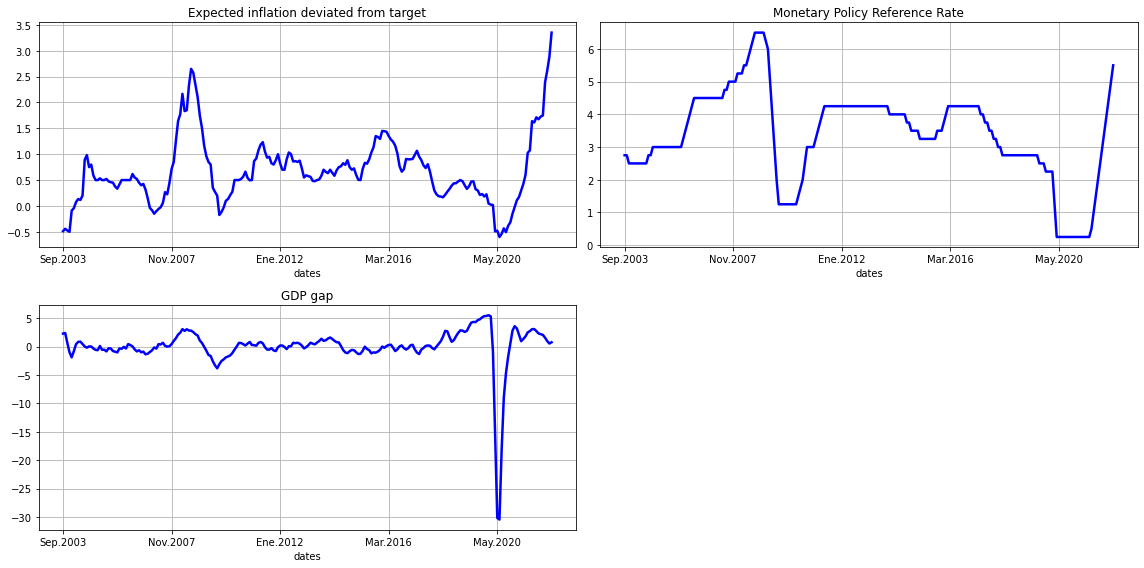

In [3]:
fig, axis = plt.subplots(nrows = 2,
                         ncols = 2,
                         figsize = (16,8))

var_names = ["Expected inflation deviated from target",
         "Monetary Policy Reference Rate",
         "GDP gap"]

# Loop for subplot
idx = 1

for i in range(2):
    for j in range (2):
        
        # if idx is minor to number of elements
        if idx <= len(var_list) - 1:
            ax = axis[i][j]
            data.plot(x = "dates",
                        y = var_list[idx],
                        ax = ax,
                        color = 'blue',
                        linewidth=2.5,
                        legend = False)
            
            ax.set_title(var_names[idx-1])
            ax.grid(which='major')
            idx = idx + 1
            
        # if idx is major to number of elements        
        else:        
            axis[i,j].axis('off')
            idx = idx + 1
            
fig.tight_layout()

plt.savefig(r".\images\er_variables.png", bbox_inches='tight')
plt.savefig(r".\images\er_variables.eps", bbox_inches='tight')

## <a id='exp_r'> Expected Monetary Policy Interest Rate </a>

In [4]:
# Initial parameters
expected_rate = data.loc[:,"mon_rate"].copy()
ρ = 0.89
i_star = 1.8

# Looping taylor rule 
for t in range(0,len(data)-1):
    expected_rate.loc[t+1] = (
        ρ*data["mon_rate"][t] 
        + (1-ρ)*(i_star + 1.5*data["inflation_gap"][t+1] + 0.5*data["gdp_gap"][t+1])
    )
    if expected_rate[t+1] < 0:
        expected_rate[t+1] = 0
        
# Final data previsualization        
data = data.assign(expected_rate = expected_rate)
data

,dates,inflation_gap,mon_rate,gdp_gap,expected_rate
0,Sep.2003,-0.487500,2.75,2.279345,2.750000
1,Oct.2003,-0.441667,2.75,2.394232,2.704308
2,Nov.2003,-0.475000,2.50,0.624506,2.601473
3,Dic.2003,-0.500000,2.50,-1.019834,2.284409
4,Ene.2004,-0.091667,2.50,-1.898041,2.303483
...,...,...,...,...,...
221,Feb.2022,1.750000,3.50,2.051270,3.269570
222,Mar.2022,2.387500,4.00,1.559817,3.792727
223,Abr.2022,2.616667,4.50,0.967112,4.242941
224,May.2022,2.885417,5.00,0.531714,4.708338


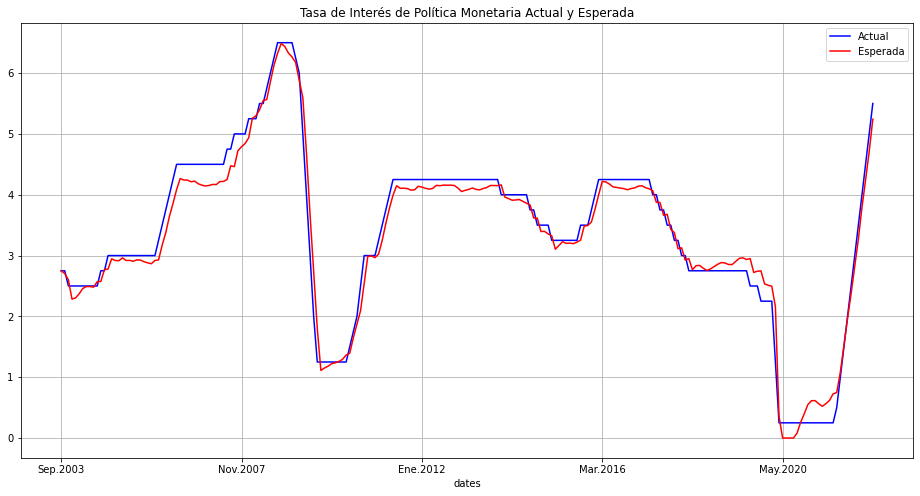

In [5]:
# Graficando
fig, ax = plt.subplots(figsize=(16,8))
data.plot(ax = ax,
          x="dates",
          y = ["mon_rate","expected_rate"],
          color=['b','r'],
          label =["Actual","Esperada"])
ax.set_title('Tasa de Interés de Política Monetaria Actual y Esperada')
ax.grid(which='major')

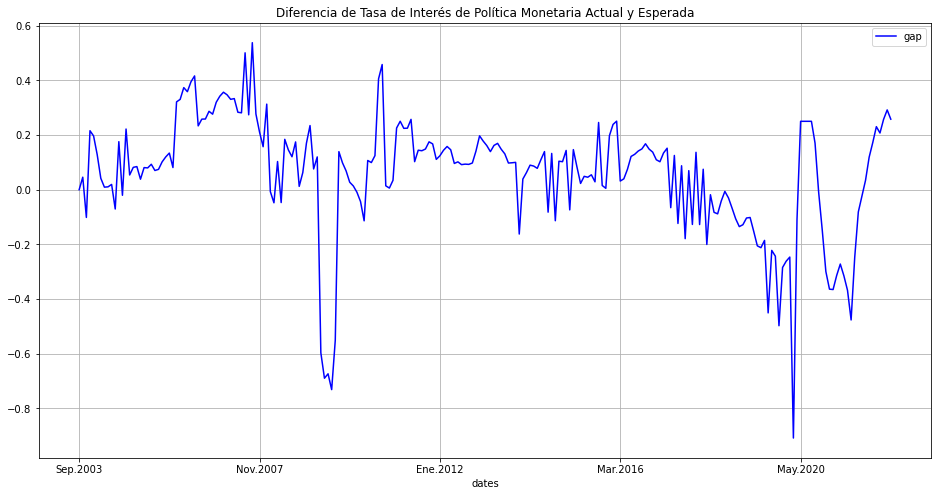

In [6]:
data["gap"] = data["mon_rate"] - data["expected_rate"]

# Graficando
fig, ax = plt.subplots(figsize=(16,8))
data.plot(ax = ax, x="dates", y="gap", color=['b'])
ax.set_title('Diferencia de Tasa de Interés de Política Monetaria Actual y Esperada')
ax.grid(which='major')

In [7]:
data.to_excel(r".\data\E(r)_result.xlsx", index = False)

## <a id='ref'>References</a>

<a id='vega'> Hugo Vega 2019 </a>. ["Perú | ¿Qué hará el Banco Central con su tasa de política en los próximos meses?"](https://www.bbvaresearch.com/wp-content/uploads/2019/04/Observatorio-Regla-Taylor-Peru-2019-2.pdf) BBVA Research, Análisis Macroeconómico.

<a id='vega'> BCRP 2017 </a>. ["Re-estimación de la tasa de interés neutral"](https://www.bcrp.gob.pe/docs/Publicaciones/Reporte-Inflacion/2017/setiembre/ri-setiembre-2017-recuadro-2.pdf) Recuadros del reporte de inflación.
